In [1]:

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm

In [2]:
# Wczytaj plik
df = pd.read_csv('fuel_output.csv', sep=';')

# Wyodrębnij kolumny do zmiennych
dates = pd.to_datetime(df['Date'])

fuel_data = df['fuel_data']
logret_fuel_data = df['logret_fuel_data'][1:]
logret_fuel_data=logret_fuel_data.values

A) metoda parametryczna - paliwo t-student

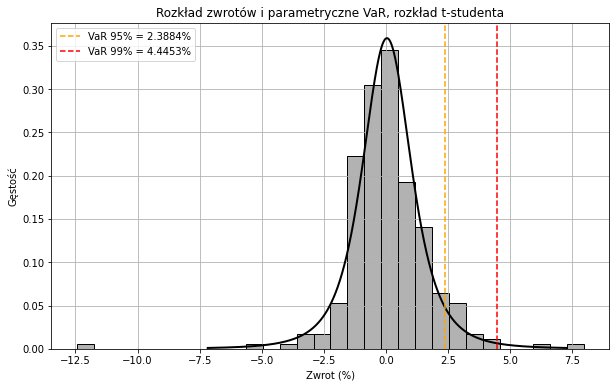

3.243723713943763 0.000355716098170116 0.010305755405206837


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


# Dopasowanie rozkładu studenta-t
df, loc, scale = stats.t.fit(logret_fuel_data)

# Wyznaczenie VaR na prawej stronie (duże zyski = prawe ogony)
alpha_95 = 0.95
alpha_99 = 0.99

z_95 = stats.t.ppf(alpha_95, df)
z_99 = stats.t.ppf(alpha_99, df)

VaR_95 = loc + z_95 * scale
VaR_99 = loc + z_99 * scale

x = np.linspace(loc - 7*scale, loc + 7*scale, 1000)
pdf = stats.t.pdf(x, df, loc, scale) / 100


x = x * 100

# Rysowanie
plt.figure(figsize=(10, 6))
sns.histplot(logret_fuel_data * 100, stat='density', bins=30, color='gray', alpha=0.6)
plt.plot(x, pdf, linewidth=2, color='black')

# Linie VaR (po prawej stronie)
plt.axvline(VaR_95 * 100, color='orange', linestyle='--', label=f"VaR 95% = {VaR_95*100:.4f}%")
plt.axvline(VaR_99 * 100, color='red', linestyle='--', label=f"VaR 99% = {VaR_99*100:.4f}%")

# Oznaczenia
plt.title('Rozkład zwrotów i parametryczne VaR, rozkład t-studenta')
plt.xlabel('Zwrot (%)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True)
plt.show()
print(df, loc, scale)


test Kolmogorova-Smirnova

KS test D-statistic: 0.0442
KS test p-value: 0.6949


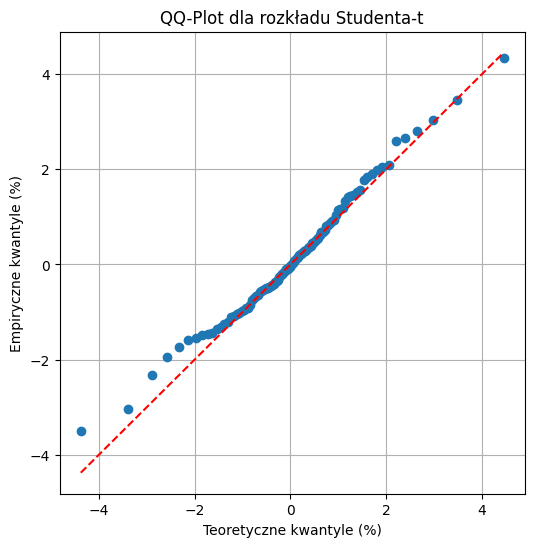

In [4]:

# Test dopasowania: Kolmogorov-Smirnov
D_statistic, p_value = stats.kstest(logret_fuel_data, 't', args=(df, loc, scale))

print(f"KS test D-statistic: {D_statistic:.4f}")
print(f"KS test p-value: {p_value:.4f}")

# QQ-plot (kwantyl-kwantyl)
theoretical_quantiles = stats.t.ppf(np.linspace(0.01, 0.99, 100), df, loc, scale)
sample_quantiles = np.quantile(logret_fuel_data, np.linspace(0.01, 0.99, 100))

plt.figure(figsize=(6, 6))
plt.plot(theoretical_quantiles * 100, sample_quantiles * 100, 'o')
plt.plot(theoretical_quantiles * 100, theoretical_quantiles * 100, 'r--')
plt.title('QQ-Plot dla rozkładu Studenta-t')
plt.xlabel('Teoretyczne kwantyle (%)')
plt.ylabel('Empiryczne kwantyle (%)')
plt.grid(True)
plt.show()


b) metoda historyczna

i) zwykla

In [4]:
alpha_95 = 0.95
alpha_99 = 0.99

# Historyczny VaR (zwykły)
VaR_hist_95 = np.percentile(logret_fuel_data, 100 * alpha_95)
VaR_hist_99 = np.percentile(logret_fuel_data, 100 * alpha_99)

print(f"Historyczny VaR 95% (zwykły): {VaR_hist_95*100:.4f}%")
print(f"Historyczny VaR 99% (zwykły): {VaR_hist_99*100:.4f}%")


Historyczny VaR 95% (zwykły): 2.6462%
Historyczny VaR 99% (zwykły): 4.3359%


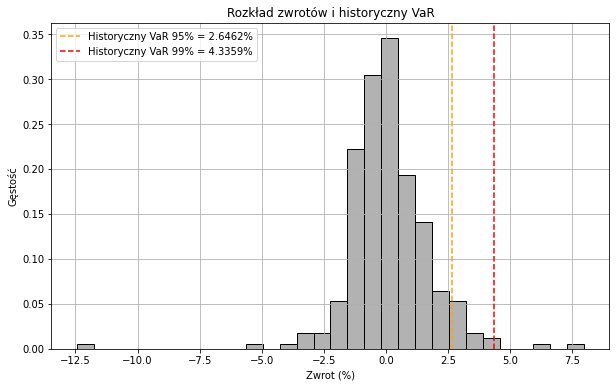

In [5]:
# Rysowanie
plt.figure(figsize=(10, 6))
sns.histplot(logret_fuel_data * 100, stat='density', bins=30, color='gray', alpha=0.6)

# Linie VaR (lewy ogon – straty)
plt.axvline(VaR_hist_95 * 100, color='orange', linestyle='--', label=f"Historyczny VaR 95% = {VaR_hist_95*100:.4f}%")
plt.axvline(VaR_hist_99 * 100, color='red', linestyle='--', label=f"Historyczny VaR 99% = {VaR_hist_99*100:.4f}%")

# Oznaczenia
plt.title('Rozkład zwrotów i historyczny VaR')
plt.xlabel('Zwrot (%)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True)
plt.show()

ii) ważony -  wagi wykładnicze, czyli najnowsze dane mają większe znaczenie.

In [6]:
# przykładowe dane

alpha_95 = 0.95
alpha_99 = 0.99

# Parametry wag
lambda_ = 0.94
n = len(logret_fuel_data)

# Wagi wykładnicze
weights = (1 - lambda_) * (lambda_ ** np.arange(n))
weights = weights[::-1]  # Najnowsze dane mają największe wagi
weights /= weights.sum()  # Normalizacja

# Sortowanie danych i wag

sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# Skumulowane wagi
cum_weights = np.cumsum(sorted_weights)

# Funkcja do wyszukiwania VaR przy skumulowanych wagach
def weighted_var(cum_weights, sorted_returns, alpha):
    idx = np.searchsorted(cum_weights, alpha, side="left")  # UWAGA: szukamy 1 - alpha
    idx = min(idx, len(sorted_returns) - 1)  # Zabezpieczenie
    return sorted_returns[idx]

# Obliczenie VaR 95% i 99%
VaR_weighted_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95*100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99*100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%


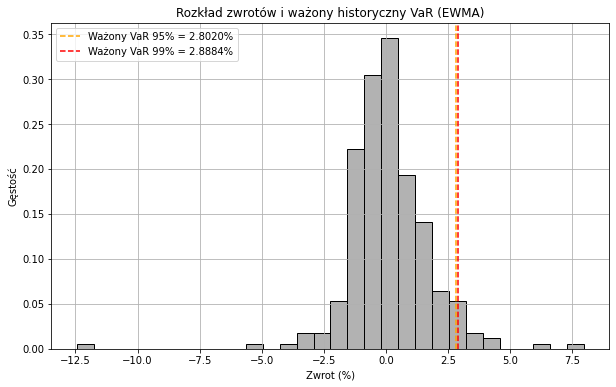

In [7]:
# Wykres
plt.figure(figsize=(10, 6))
sns.histplot(logret_fuel_data * 100, stat='density', bins=30, color='gray', alpha=0.6)

# Linie VaR
plt.axvline(VaR_weighted_95 * 100, color='orange', linestyle='--', label=f"Ważony VaR 95% = {VaR_weighted_95*100:.4f}%")
plt.axvline(VaR_weighted_99 * 100, color='red', linestyle='--', label=f"Ważony VaR 99% = {VaR_weighted_99*100:.4f}%")

# Oznaczenia
plt.title('Rozkład zwrotów i ważony historyczny VaR (EWMA)')
plt.xlabel('Zwrot (%)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True)
plt.show()

In [9]:


# Parametry
lambda_ = 0.96
alpha_95 = 0.95
alpha_99 = 0.99

# Dane: załóżmy, że masz już wczytane logret_fuel_data jako np.array
n = len(logret_fuel_data)

# 1. Wyznaczanie wag wykładniczych zgodnie z metodą
raw_weights = lambda_ ** np.arange(n-1, -1, -1)  # lambda^0 dla najnowszej obserwacji
w1 = (1 - lambda_) / (1 - lambda_ ** n)           # Wyznaczenie w(1) z warunku normalizacji
weights = w1 * raw_weights                       # Ostateczne wagi
weights /= weights.sum()                         # (opcjonalna dodatkowa normalizacja dla bezpieczeństwa)

# 2. Sortowanie danych wg wartości zwrotów
sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# 3. Skumulowane prawdopodobieństwa
cum_weights = np.cumsum(sorted_weights)

# 4. Funkcja do wyszukiwania VaR
def weighted_var(cum_weights, sorted_returns, alpha):
    target = alpha  # szukamy kwantyla na poziomie 1 - alpha
    idx = np.searchsorted(cum_weights, target, side="left")
    idx = min(idx, len(sorted_returns) - 1)  # zabezpieczenie
    return sorted_returns[idx]

# 5. Obliczenie VaR
VaR_weighted_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95*100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99*100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%


iii) GARCH

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                680.538
Distribution:                  Normal   AIC:                          -1353.08
Method:            Maximum Likelihood   BIC:                          -1338.97
                                        No. Observations:                  251
Date:                Mon, Apr 28 2025   Df Residuals:                      250
Time:                        20:31:22   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.8238e-04  1.777e-03     -0.159      0.

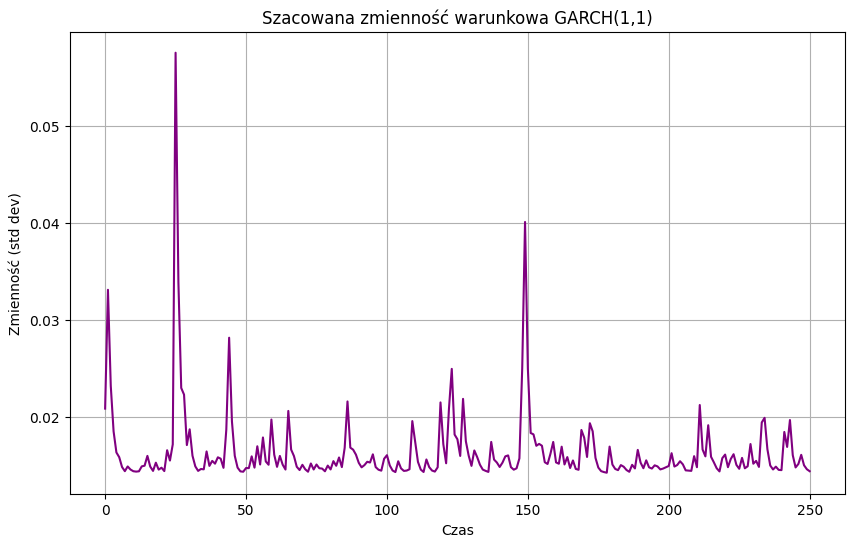

In [10]:
from arch import arch_model

# Przygotowanie danych
returns = logret_fuel_data  # Twoje logarytmiczne stopy zwrotu

# Dopasowanie modelu GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Wyświetlenie pełnego podsumowania modelu
print(garch_fit.summary())

# Wykres zmienności (warunkowej standard deviation)
plt.figure(figsize=(10,6))
plt.plot(garch_fit.conditional_volatility, color='purple')
plt.title('Szacowana zmienność warunkowa GARCH(1,1)')
plt.xlabel('Czas')
plt.ylabel('Zmienność (std dev)')
plt.grid(True)
plt.show()


In [11]:
# Dopasowanie modelu GARCH(1,1)
model = arch_model(logret_fuel_data, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Obliczenie zmienności warunkowej (standard deviation) z modelu GARCH
conditional_volatility = garch_fit.conditional_volatility

# Obliczanie VaR na poziomie 95% i 99% dla modelu GARCH
VaR_garch_95 = np.percentile(conditional_volatility, 5)  # 5% percentyl dla VaR 95%
VaR_garch_99 = np.percentile(conditional_volatility, 1)  # 1% percentyl dla VaR 99%

# Wyświetlanie wyników VaR w procentach
print(f"GARCH VaR 95%: {VaR_garch_95 * 100:.4f}%")
print(f"GARCH VaR 99%: {VaR_garch_99 * 100:.4f}%")

GARCH VaR 95%: 1.4402%
GARCH VaR 99%: 1.4325%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


c) Monte Carlo

t-student

In [10]:
N = 10000  # Duża liczba losowań (żeby kwantyle były dokładne)

# Symulacja zwrotów
simulated_returns =stats.t.rvs(df,loc,scale,size=N)

# Liczenie VaR 95% i 99% z symulowanych danych
VaR_mc_95_t = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99_t = np.percentile(simulated_returns, 100 * 0.99)

print(f"Monte Carlo VaR 95%: {VaR_mc_95_t*100:.4f}%")
print(f"Monte Carlo VaR 99%: {VaR_mc_99_t*100:.4f}%")


Monte Carlo VaR 95%: 2.4179%
Monte Carlo VaR 99%: 4.5354%


In [11]:
import statsmodels.api as sm

# Dopasowanie modelu ARMA(1,1)
arma_model = sm.tsa.ARIMA(logret_fuel_data, order=(1,0, 1)).fit()

# Wyciągnięcie parametrów
arparams = arma_model.arparams
maparams = arma_model.maparams
sigma = np.std(arma_model.resid, ddof=1)

# Parametry Monte Carlo
n_simulations = 100000  # Ilość symulacji
n_steps = 1  # Jednokrokowe symulacje (jednodniowe VaR)

# Symulacja procesów ARMA(1,1)
simulated_returns = []
for _ in range(n_simulations):
    # Symulacja białego szumu
    eps = np.random.normal(0, sigma, n_steps + 1)
    
    # Symulacja procesu
    x = np.zeros(n_steps + 1)
    for t in range(1, n_steps + 1):
        x[t] = arparams[0] * x[t-1] + eps[t] + maparams[0] * eps[t-1]
    
    simulated_returns.append(x[-1])  # interesuje nas ostatnia wartość (krok n_steps)

simulated_returns = np.array(simulated_returns)

# Liczenie VaR
VaR_mc_95 = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99 = np.percentile(simulated_returns, 100 * 0.99)

print(f"Monte Carlo VaR 95% (ARMA(1,1)): {VaR_mc_95*100:.4f}%")
print(f"Monte Carlo VaR 99% (ARMA(1,1)): {VaR_mc_99*100:.4f}%")


Monte Carlo VaR 95% (ARMA(1,1)): 3.2620%
Monte Carlo VaR 99% (ARMA(1,1)): 4.6321%


podsumowanie:

In [17]:
import pandas as pd

# Dane: wpisujemy wartości VaR w procentach
var_results = pd.DataFrame({
    "VaR 95%": [
        VaR_95 * 100,  # Parametryczna (Normalna)
        VaR_hist_95*100,  # Historyczna (Zwykła)
        VaR_weighted_95*100,
        VaR_mc_95_t*100,  # Historyczna (Ważona)
        VaR_mc_95*100  # Monte Carlo (Normalna   # Monte Carlo (ARMA(1,1))
    ],
    "VaR 99%": [
        VaR_99 * 100,  # Parametryczna (Normalna)
        VaR_hist_99*100,  # Historyczna (Zwykła)
        VaR_weighted_99*100,
        VaR_mc_99_t*100,# Historyczna (Ważona)
        VaR_mc_99*100  # Monte Carlo (Normalna)   # Monte Carlo (ARMA(1,1))
    ]
}, index=[
    "Parametryczna (Normalna)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (Normalna)",
    "Monte Carlo (ARMA(1,1))"
])

# Wyświetlenie tabeli
var_results.round(4)


,VaR 95%,VaR 99%
Parametryczna (Normalna),2.3884,4.4453
Historyczna (Zwykła),2.6462,4.3359
Historyczna (Ważona),2.8020,2.8884
Monte Carlo (Normalna),2.5208,4.7740
"Monte Carlo (ARMA(1,1))",3.2382,4.5907


z GARCHem

In [16]:
var_results = pd.DataFrame({
    "VaR 95%": [
        VaR_95 * 100,  # Parametryczna (Normalna)
        VaR_hist_95 * 100,  # Historyczna (Zwykła)
        VaR_weighted_95 * 100,
        VaR_mc_95_t * 100,  # Historyczna (Ważona)
        VaR_mc_95 * 100,  # Monte Carlo (Normalna)
        VaR_garch_95 * 100  # GARCH
    ],
    "VaR 99%": [
        VaR_99 * 100,  # Parametryczna (Normalna)
        VaR_hist_99 * 100,  # Historyczna (Zwykła)
        VaR_weighted_99 * 100,
        VaR_mc_99_t * 100,  # Historyczna (Ważona)
        VaR_mc_99 * 100,  # Monte Carlo (Normalna)
        VaR_garch_99 * 100  # GARCH
    ]
}, index=[
    "Parametryczna (Normalna)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (Normalna)",
    "Monte Carlo (ARMA(1,1))",
    "GARCH"
])

# Wyświetlenie tabeli
var_results.round(4)

,VaR 95%,VaR 99%
Parametryczna (Normalna),2.3884,4.4453
Historyczna (Zwykła),2.6462,4.3359
Historyczna (Ważona),2.8020,2.8884
Monte Carlo (Normalna),2.3514,4.5229
"Monte Carlo (ARMA(1,1))",3.2459,4.6156
GARCH,1.4402,1.4325


# Testowanie wsteczne

In [10]:
from scipy.stats import chi2, norm

def kupiec_test(returns, var, alpha):
    T = len(returns)
    breaches = returns < var
    n_breaches = breaches.sum()
    pi = n_breaches / T
    likelihood_ratio = -2 * ( 
        (n_breaches * np.log(alpha) + (T - n_breaches) * np.log(1 - alpha)) - 
        (n_breaches * np.log(pi) + (T - n_breaches) * np.log(1 - pi))
    )
    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value, n_breaches

def christoffersen_test(returns, var):
    T = len(returns)
    breaches = (returns < var).astype(int)
    n00 = np.sum((breaches[:-1] == 0) & (breaches[1:] == 0))
    n01 = np.sum((breaches[:-1] == 0) & (breaches[1:] == 1))
    n10 = np.sum((breaches[:-1] == 1) & (breaches[1:] == 0))
    n11 = np.sum((breaches[:-1] == 1) & (breaches[1:] == 1))
    
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    L0 = ((1 - pi)**(n00 + n10)) * (pi**(n01 + n11))
    L1 = ((1 - pi01)**n00) * (pi01**n01) * ((1 - pi11)**n10) * (pi11**n11)
    if L0 == 0 or L1 == 0:
        likelihood_ratio = np.nan
        p_value = np.nan
    else:
        likelihood_ratio = -2 * np.log(L0 / L1)
        p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value

def berkowitz_test(returns, var, alpha):
    breaches = (returns < var).astype(int)
    pit = alpha * breaches + (1 - alpha) * (1 - breaches)
    z = norm.ppf(pit)
    z = z[np.isfinite(z)]
    
    mu = np.mean(z)
    sigma2 = np.var(z, ddof=1)
    
    LR = len(z) * (mu**2 + (sigma2 - 1)**2 / 2)
    p_value = 1 - chi2.cdf(LR, df=2)
    return LR, p_value

In [20]:
returns = logret_fuel_data


methods = {
    "Parametryczna (Normalna)": (VaR_95 / 100, VaR_99 / 100),
    "Historyczna (Zwykła)": (VaR_hist_95 / 100, VaR_hist_99 / 100),
    "Historyczna (Ważona)": (VaR_weighted_95 / 100, VaR_weighted_99 / 100),
    "Monte Carlo (t-Studenta)": (VaR_mc_95_t / 100, VaR_mc_99_t / 100),
    "Monte Carlo (Normalna)": (VaR_mc_95 / 100, VaR_mc_99 / 100),
    #"GARCH": (VaR_garch_95 / 100, VaR_garch_99 / 100)
}

results = []


for method, (var95, var99) in methods.items():
    for alpha, var in zip([0.05, 0.01], [var95, var99]):
        kupiec_stat, kupiec_p, breaches = kupiec_test(returns, var, alpha)
        christ_stat, christ_p = christoffersen_test(returns, var)
        berko_stat, berko_p = berkowitz_test(returns, var, alpha)
        
        results.append({
            "Metoda": method,
            "Poziom VaR": f"{int((1-alpha)*100)}%",
            "Przekroczenia": breaches,
            "Kupiec stat": kupiec_stat,
            "Kupiec p-value": kupiec_p,
            "Christoffersen stat": christ_stat,
            "Christoffersen p-value": christ_p,
            "Berkowitz stat": berko_stat,
            "Berkowitz p-value": berko_p
        })


results_df = pd.DataFrame(results)
results_df

,Metoda,Poziom VaR,Przekroczenia,Kupiec stat,Kupiec p-value,Christoffersen stat,Christoffersen p-value,Berkowitz stat,Berkowitz p-value
0,Parametryczna (Normalna),95%,126,419.791956,0.0,11.750752,0.000608,369.704031,0.0
1,Parametryczna (Normalna),99%,129,842.821550,0.0,9.982539,0.001580,2463.220940,0.0
2,Historyczna (Zwykła),95%,127,425.712707,0.0,10.046431,0.001526,369.641684,0.0
3,Historyczna (Zwykła),99%,129,842.821550,0.0,9.982539,0.001580,2463.220940,0.0
4,Historyczna (Ważona),95%,127,425.712707,0.0,10.046431,0.001526,369.641684,0.0
5,Historyczna (Ważona),99%,128,833.535674,0.0,10.019793,0.001549,2465.005221,0.0
6,Monte Carlo (t-Studenta),95%,127,425.712707,0.0,10.046431,0.001526,369.641684,0.0
7,Monte Carlo (t-Studenta),99%,129,842.821550,0.0,9.982539,0.001580,2463.220940,0.0
8,Monte Carlo (Normalna),95%,128,431.665336,0.0,10.019793,0.001549,369.517079,0.0
9,Monte Carlo (Normalna),99%,129,842.821550,0.0,9.982539,0.001580,2463.220940,0.0


In [ ]:
#problem z biblioteką

from vartests.tests import KupiecTest, ChristoffersenTest, BerkowitzTest

# Przypisanie metod i VaR
methods = {
    "Parametryczna (Normalna)": (VaR_95 / 100, VaR_99 / 100),
    "Historyczna (Zwykła)": (VaR_hist_95 / 100, VaR_hist_99 / 100),
    "Historyczna (Ważona)": (VaR_weighted_95 / 100, VaR_weighted_99 / 100),
    "Monte Carlo (t-Studenta)": (VaR_mc_95_t / 100, VaR_mc_99_t / 100),
    "Monte Carlo (Normalna)": (VaR_mc_95 / 100, VaR_mc_99 / 100),
    # "GARCH" 
}

# Lista wyników
results = []

for method, (var95, var99) in methods.items():
    for alpha, var in zip([0.05, 0.01], [var95, var99]):

        # Test Kupca
        kupiec = KupiecTest(returns, var, alpha=alpha)
        kupiec.test()

        # Test Christoffersen'a
        christoffersen = ChristoffersenTest(returns, var, alpha=alpha)
        christoffersen.test()

        # Test Berkowitza
        berkowitz = BerkowitzTest(returns, var, alpha=alpha)
        berkowitz.test()

        results.append({
            "Metoda": method,
            "Poziom VaR": f"{int((1-alpha)*100)}%",
            "Przekroczenia": (returns < -var).sum(),
            "Kupiec stat": kupiec.statistic,
            "Kupiec p-value": kupiec.pvalue,
            "Christoffersen stat": christoffersen.statistic,
            "Christoffersen p-value": christoffersen.pvalue,
            "Berkowitz stat": berkowitz.statistic,
            "Berkowitz p-value": berkowitz.pvalue
        })

# Tworzenie ładnej tabeli wyników
results_df = pd.DataFrame(results)
print(results_df)


ModuleNotFoundError: No module named 'vartests'

In [16]:
from scipy.stats import chi2, norm
import pandas as pd
import numpy as np

def bern_test(p, v):
    lv = len(v)
    sv = sum(v)
    L_pi = -(np.log(p)*sv + np.log(1 - p)*(lv - sv))  # log-likelihood under H0
    L_hat = np.log(sv / lv)*sv + np.log(1 - sv / lv)*(lv - sv) if 0 < sv < lv else L_pi
    stat = -2 * (L_pi - L_hat)
    return stat, L_pi

def ind_test(V):
    T = len(V)
    J = np.full([T, 4], 0)
    for i in range(1, len(V) - 1):
        J[i, 0] = (V[i - 1] == 0) & (V[i] == 0)
        J[i, 1] = (V[i - 1] == 0) & (V[i] == 1)
        J[i, 2] = (V[i - 1] == 1) & (V[i] == 0)
        J[i, 3] = (V[i - 1] == 1) & (V[i] == 1)
    V_00 = sum(J[:, 0])
    V_01 = sum(J[:, 1])
    V_10 = sum(J[:, 2])
    V_11 = sum(J[:, 3])
    p_00 = V_00 / (V_00 + V_01) if (V_00 + V_01) > 0 else 0
    p_01 = V_01 / (V_00 + V_01) if (V_00 + V_01) > 0 else 0
    p_10 = V_10 / (V_10 + V_11) if (V_10 + V_11) > 0 else 0
    p_11 = V_11 / (V_10 + V_11) if (V_10 + V_11) > 0 else 0
    hat_p = (V_01 + V_11) / (V_00 + V_01 + V_10 + V_11)
    al = np.log(1 - hat_p)*(V_00 + V_10) + np.log(hat_p)*(V_01 + V_11)
    bl = 0
    if p_00 > 0: bl += np.log(p_00)*V_00
    if p_01 > 0: bl += np.log(p_01)*V_01
    if p_10 > 0: bl += np.log(p_10)*V_10
    if p_11 > 0: bl += np.log(p_11)*V_11
    stat = -2 * (al - bl)
    return stat

def berkowitz_test(returns, var, alpha):
    breaches = (returns < var).astype(int)
    pit = alpha * breaches + (1 - alpha) * (1 - breaches)
    z = norm.ppf(pit)
    z = z[np.isfinite(z)]
    mu = np.mean(z)
    sigma2 = np.var(z, ddof=1)
    LR = len(z) * (mu**2 + (sigma2 - 1)**2 / 2)
    p_value = 1 - chi2.cdf(LR, df=2)
    return LR

# Dane wejściowe
returns = logret_fuel_data

methods = {
    "Parametryczna (Normalna)": (VaR_95 / 100, VaR_99 / 100),
    "Historyczna (Zwykła)": (VaR_hist_95 / 100, VaR_hist_99 / 100),
    "Historyczna (Ważona)": (VaR_weighted_95 / 100, VaR_weighted_99 / 100),
    "Monte Carlo (t-Studenta)": (VaR_mc_95_t / 100, VaR_mc_99_t / 100),
    "Monte Carlo (Normalna)": (VaR_mc_95 / 100, VaR_mc_99 / 100),
    # "GARCH": (VaR_garch_95 / 100, VaR_garch_99 / 100)
}

results = []

for method, (var95, var99) in methods.items():
    for alpha, var in zip([0.05, 0.01], [var95, var99]):
        breaches = (returns < var).astype(int)
        emp_freq = breaches.mean()
        EI = alpha * len(returns)

        # Test Bernoulliego
        bern_stat, logL_pi = bern_test(alpha, breaches)

        # Test niezależności
        ind_stat = ind_test(breaches)

        # Test Berkowitza
        berk_stat = berkowitz_test(returns, var, alpha)

        results.append({
            "Metoda": method,
            "Poziom VaR": f"{int((1 - alpha) * 100)}%",
            "L(π)": logL_pi,
            "EI": EI,
            "Średnia próbki": emp_freq,
            "Kupiec stat": bern_stat,
            "Christoffersen stat": ind_stat,
            "Berkowitz stat": berk_stat
        })

results_df = pd.DataFrame(results)
results_df


,Metoda,Poziom VaR,L(π),EI,Średnia próbki,Kupiec stat,Christoffersen stat,Berkowitz stat
0,Parametryczna (Normalna),95%,383.873928,12.55,0.501992,-1115.703757,11.355206,369.704031
1,Parametryczna (Normalna),99%,595.293095,2.51,0.513944,-1538.350830,9.599001,2463.220940
2,Historyczna (Zwykła),95%,386.818367,12.55,0.505976,-1121.560762,9.672790,369.641684
3,Historyczna (Zwykła),99%,595.293095,2.51,0.513944,-1538.350830,9.599001,2463.220940
4,Historyczna (Ważona),95%,386.818367,12.55,0.505976,-1121.560762,9.672790,369.641684
5,Historyczna (Ważona),99%,590.697975,2.51,0.509960,-1529.256227,9.641144,2465.005221
6,Monte Carlo (t-Studenta),95%,383.873928,12.55,0.501992,-1115.703757,11.355206,369.704031
7,Monte Carlo (t-Studenta),99%,595.293095,2.51,0.513944,-1538.350830,9.599001,2463.220940
8,Monte Carlo (Normalna),95%,389.762806,12.55,0.509960,-1127.385889,9.641144,369.517079
9,Monte Carlo (Normalna),99%,595.293095,2.51,0.513944,-1538.350830,9.599001,2463.220940
